In [1]:
import numpy as np
import matplotlib
import random
import seaborn as sn
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Plot matrix of covariance
def plot_cm(population):
    population = np.array(population)
    covMatrix = np.cov(population, bias=True)
    sn.heatmap(covMatrix, annot=True, fmt='g')
    plt.show()

# Plot progress: The scores starts to converge
def plotation(best_score_progress):
    plt.plot(best_score_progress)
    plt.xlabel('Generation')
    plt.ylabel('Best score (% target)')
    plt.show()

In [3]:
# Aptitude function one max problem
def one_max_fitness(candidate):
    _str = ""
    for i in candidate:
        _str += str(int(i))
    f = int(_str,2)
    #print(_str," ",f)
    return f

def ftrap_5(candidate):
    f = 0
    for i in range(0,len(candidate),5):
        trap = candidate[i:i+5]
        trap = np.asarray(trap)
        u = np.count_nonzero(trap)
        if u < 5:
            f += 4 - u
        else:
            f += 5
    return f

def inv_ftrap_5(candidate):
    f = 0
    for i in range(0,len(candidate),5):
        trap = candidate[i:i+5]
        trap = np.asarray(trap)
        u = np.count_nonzero(trap)
        if u == 0:
            f += 5
        else:
            f += u -1
    return f

SGA

In [4]:
# Create the initial population (random)
def create_starting_population_sga(individuals, chromosome_length):
    population = np.random.randint(2, size=(individuals,chromosome_length))
    return population

In [5]:
def selection_by_tournament(population_size ,population,scores,crossover_rate):
    # Create new population generating two children at a time
    new_population = []
    for i in range(int(population_size)):
        parent_1 = select_individual_by_tournament(population, scores)
        parent_2 = select_individual_by_tournament(population, scores)
        child_1, child_2 = crossover(parent_1, parent_2, crossover_rate)
        new_population.append(child_1)
        new_population.append(child_2)
    return new_population

def select_individual_by_tournament(population, scores):
    # Get population size
    population_size = len(scores)

    # Pick individuals for tournament
    fighter_1 = random.randint(0, population_size - 1)
    fighter_2 = random.randint(0, population_size - 1)

    # Get fitness score for each
    fighter_1_fitness = scores[fighter_1]
    fighter_2_fitness = scores[fighter_2]

    while fighter_2_fitness == fighter_1_fitness:
        fighter_2_fitness = random.randint(0, population_size - 1)

    # Identify individual with highest fitness
    # Fighter 1 will win if score are equal
    if fighter_1_fitness >= fighter_2_fitness:
        winner = fighter_1
    else:
        winner = fighter_2

    # Return the chromosome of the winner
    return population[winner, :]


def crossover(parent_1, parent_2,crossover_rate):
    # If we arise the probability , then we me crossover
    probability = np.random.random()
    if probability <= crossover_rate:
        # Get length of chromosome
        chromosome_length = len(parent_1)

        # Pick crossover point, avoding ends of chromosome
        crossover_point = random.randint(1, chromosome_length - 1)

        # Create children. np.hstack joins two arrays
        child_1 = np.hstack((parent_1[0:crossover_point],
                             parent_2[crossover_point:]))

        child_2 = np.hstack((parent_2[0:crossover_point],
                             parent_1[crossover_point:]))

    else:
        child_1 = parent_1
        child_2 = parent_2

    # Return children
    return child_1, child_2



def randomly_mutate_population(population, mutation_probability):
    # Apply random mutation
    random_mutation_array = np.random.random(
        size=(population.shape))

    random_mutation_boolean = (random_mutation_array <= mutation_probability)

    population[random_mutation_boolean] = \
        np.logical_not(population[random_mutation_boolean])

    # Return mutation population
    return population

In [6]:
def run_sga(chromosome_length,population_size,maximum_generation,crossover_rate,mutation_rate,fitness_obj):
    best_score_progress = []  # Tracks progress
    best_score_progress.append(0)
    best = []
    best_fitness = -1
    population = create_starting_population_sga(population_size, chromosome_length)
    #print('Initial population: \n{}'.format(population))
    scores = np.asarray([fitness_obj(ind) for ind in population])

    # Now we'll go through the generations of genetic algorithm
    #print("First score: ",scores)
    for generation in range(maximum_generation):
        # Winner of generation (i)
        winner_fitness = np.amax(scores)
        winner = population[np.where(scores == np.amax(scores))][0]
        #print("Max Fitness: ",winner_fitness," Solution: ",winner)
        if len(best) > 0:
            if winner_fitness > best_fitness:
                best = winner
                best_fitness = winner_fitness
        else:
            best = winner
            best_fitness = winner_fitness

        best_score_progress.append(best_fitness)

        # Create an new population & applies cross over
        new_population = selection_by_tournament(population_size ,population,scores,crossover_rate)

        # Replace the old population with the new one
        population = np.array(new_population)

        # Apply mutation
        population = randomly_mutate_population(population, mutation_rate)

        # Score best solution, and add to tracker
        scores = np.asarray([fitness_obj(ind) for ind in population])

    print("SGA Best Fitness: ", best_fitness, " Best Solution: ", best)
    #plotation(best_score_progress)
    return best_score_progress


CGA

In [7]:
def generate_candidate(vector):
    value = []
    for p in vector:
        if np.random.random_sample() < p:
            value.append(1)
        else:
            value.append(0)

    return value


def generate_vector(size):
    return [0.5] * size


def compete(a_fitness, b_fitness, a, b):
    if a_fitness > b_fitness:
        return a, a_fitness, b, b_fitness
    else:
        return b, b_fitness, a, a_fitness


def update_vector(vector, winner, loser, population_size):
    for i in range(len(vector)):
        if winner[i] != loser[i]:
            if winner[i] == 1:
                vector[i] += 1.0 / float(population_size)
            else:
                vector[i] -= 1.0 / float(population_size)
    return vector


def run_cga(maximum_generation, chromosome_length, population_size, fitness_obj):
    # Probability vector 0f 50 % of be 0 or 1
    vector = generate_vector(chromosome_length)
    best_score_progress = []
    best_score_progress.append(0)
    best = []
    best_fitness = -1

    for i in range(maximum_generation):
        # Generating two candidates
        s1 = generate_candidate(vector)
        s2 = generate_candidate(vector)

        # Calculating the fitness
        s1_fitness = fitness_obj(s1)
        s2_fitness = fitness_obj(s2)

        # Competition
        winner, winner_fitness, loser, loser_fitness = compete(s1_fitness, s2_fitness, s1, s2)

        # Check the best value
        if len(best) > 0:
            if winner_fitness > best_fitness:
                best = winner
                best_fitness = winner_fitness
        else:
            best = winner
            best_fitness = winner_fitness

        best_score_progress.append(best_fitness)

        # Update the vector
        vector = update_vector(vector, winner, loser, population_size)

        #print ("generation: {} best value: {} best fitness: {}".format(i + 1, winner, float(winner_fitness)))
    print("CGA Best Fitness: ", best_fitness, " Best Solution: ", best)
    return best_score_progress




Main Method

SGA Best Fitness:  31  Best Solution:  [1 1 1 1 1]
CGA Best Fitness:  31  Best Solution:  [1, 1, 1, 1, 1]


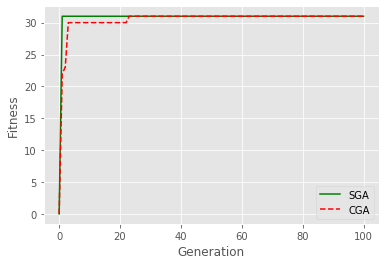

SGA Best Fitness:  1023  Best Solution:  [1 1 1 1 1 1 1 1 1 1]
CGA Best Fitness:  1023  Best Solution:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


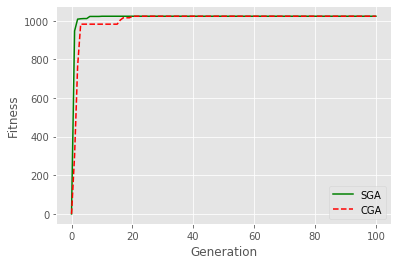

In [8]:
# Mutual Parameters
chromosome_length = 10
population_size = 20
maximum_generation = 100
fitness_obj = one_max_fitness#ftrap_5

# Binarios sGA: One Max Problem (OMP).
crossover_rate = 0.7
mutation_rate = 0.009
#best_score_progress_sga = run_sga(chromosome_length,population_size,maximum_generation,crossover_rate,mutation_rate,fitness_obj)


#-------------------------------------


# Binarios cGA: One Max Problem (OMP).
#best_score_progress_cga = run_cga(maximum_generation, chromosome_length, population_size, fitness_obj)


# Plott : To more high the dimension, more difficult to converge
for chromosome_length in [5,10]:
    best_score_progress_sga = run_sga(chromosome_length,population_size,maximum_generation,crossover_rate,mutation_rate,fitness_obj)
    best_score_progress_cga = run_cga(maximum_generation, chromosome_length, population_size, fitness_obj)
    sga_line, = plt.plot(best_score_progress_sga, color="green", linewidth=1.5, linestyle="-", label='SGA')
    cga_line, = plt.plot(best_score_progress_cga, color="red", linewidth=1.5, linestyle="dashed", label='CGA')
    plt.legend()
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.show()